In [1]:
!pip3 install yfinance --upgrade --no-cache-dir
import yfinance as yf
import numpy as np
import pandas as pd
import math
from pandas_datareader import data
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
# Get Golds daily closing price from yahoo finance

gold = yf.Ticker("GC=F")
gold_history = gold.history(period="10y")

df = pd.DataFrame(data=gold_history)
df = df.filter(items=['Close'])
df.head(5)

,Close
Date,
2012-06-25,1587.500000
2012-06-26,1574.000000
2012-06-27,1577.500000
2012-06-28,1549.699951
2012-06-29,1603.500000


In [3]:
# Rename columns and add index for easier iteration later

df.rename(columns = {'Close':'Price'}, inplace = True)
df.reset_index(inplace=True)
close = df.copy()
df.head(5)

,Date,Price
0,2012-06-25,1587.500000
1,2012-06-26,1574.000000
2,2012-06-27,1577.500000
3,2012-06-28,1549.699951
4,2012-06-29,1603.500000


In [4]:
#create mean,min and max of last 30days until most recent day. Ignore days where not enough historical data exists.
rolling_window_days = 31

for index,row in df.iterrows():
    if index-31 > 0 :
        df.loc[df.index[index], 'mean_30d'] = df['Price'][(index-rolling_window_days):index].mean()
    else:
        df.loc[df.index[index], 'mean_30d'] = np.nan

for index,row in df.iterrows():
    if index-31 > 0:
        df.loc[df.index[index], 'min_30d'] = df['Price'][(index-rolling_window_days):index].min()
    else:
        df.loc[df.index[index], 'min_30d'] = np.nan
        
for index,row in df.iterrows():
    if index-31 > 0:
        df.loc[df.index[index], 'max_30d'] = df['Price'][(index-rolling_window_days):index].max()
    else:
        df.loc[df.index[index], 'max_30d'] = np.nan

In [5]:
df.tail(5)

,Date,Price,mean_30d,min_30d,max_30d
2510,2022-06-17,1835.599976,1843.441938,1807.400024,1881.199951
2511,2022-06-21,1834.599976,1842.429034,1807.400024,1881.199951
2512,2022-06-22,1834.300049,1841.158065,1807.400024,1881.199951
2513,2022-06-23,1825.699951,1839.645165,1807.400024,1871.500000
2514,2022-06-24,1826.500000,1838.632261,1807.400024,1871.500000


<AxesSubplot:xlabel='Date'>

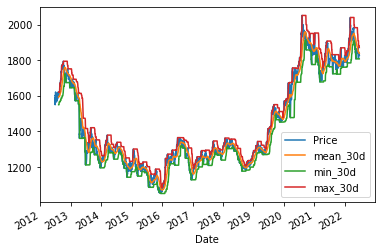

In [6]:
# sneapeak of our new values
df.plot(x='Date')

In [7]:
# If at a certain date, the price closes highest in the last 30 days
# AND the distance to mean is 75% (adjustable) higher than distance of previous max to mean: upward alert

# If at a certain date, the price closes lowest in the last 30days
# AND the distance to mean is 75% (adjustable) lower than distance of previous min to mean: downward alert



for index,row in df.iterrows():
    if df.loc[df.index[index], 'Price'] > df.loc[df.index[index], 'max_30d']\
        and math.dist([df.loc[df.index[index], 'Price']], [df.loc[df.index[index], 'mean_30d']]) >\
            math.dist([df.loc[df.index[index], 'max_30d']], [df.loc[df.index[index], 'mean_30d']])*1.75:
                df.loc[df.index[index], 'Alert'] = "Price jump alert"
    elif df.loc[df.index[index], 'Price'] < df.loc[df.index[index], 'min_30d']\
        and math.dist([df.loc[df.index[index], 'mean_30d']], [df.loc[df.index[index], 'Price']]) >\
            math.dist([df.loc[df.index[index], 'mean_30d']], [df.loc[df.index[index], 'min_30d']])*1.75:
                df.loc[df.index[index], 'Alert'] = "Price drop alert"
    else:
        pass

In [8]:
# This is the final output sheet with detected anomalies, but will split them between up and down.

df1 = df[df['Alert'].notnull()]
df.count()

Date        2515
Price       2515
mean_30d    2483
min_30d     2483
max_30d     2483
Alert         31
dtype: int64

In [9]:
up_df = df1[df1['Alert'] == 'Price jump alert']
down_df = df1[df1['Alert'] == 'Price drop alert']

In [10]:
# change Dates back to indexes in order to get dates/years in X axis when plotting
df = df.set_index('Date')
up_df = up_df.set_index('Date')
down_df = down_df.set_index('Date')

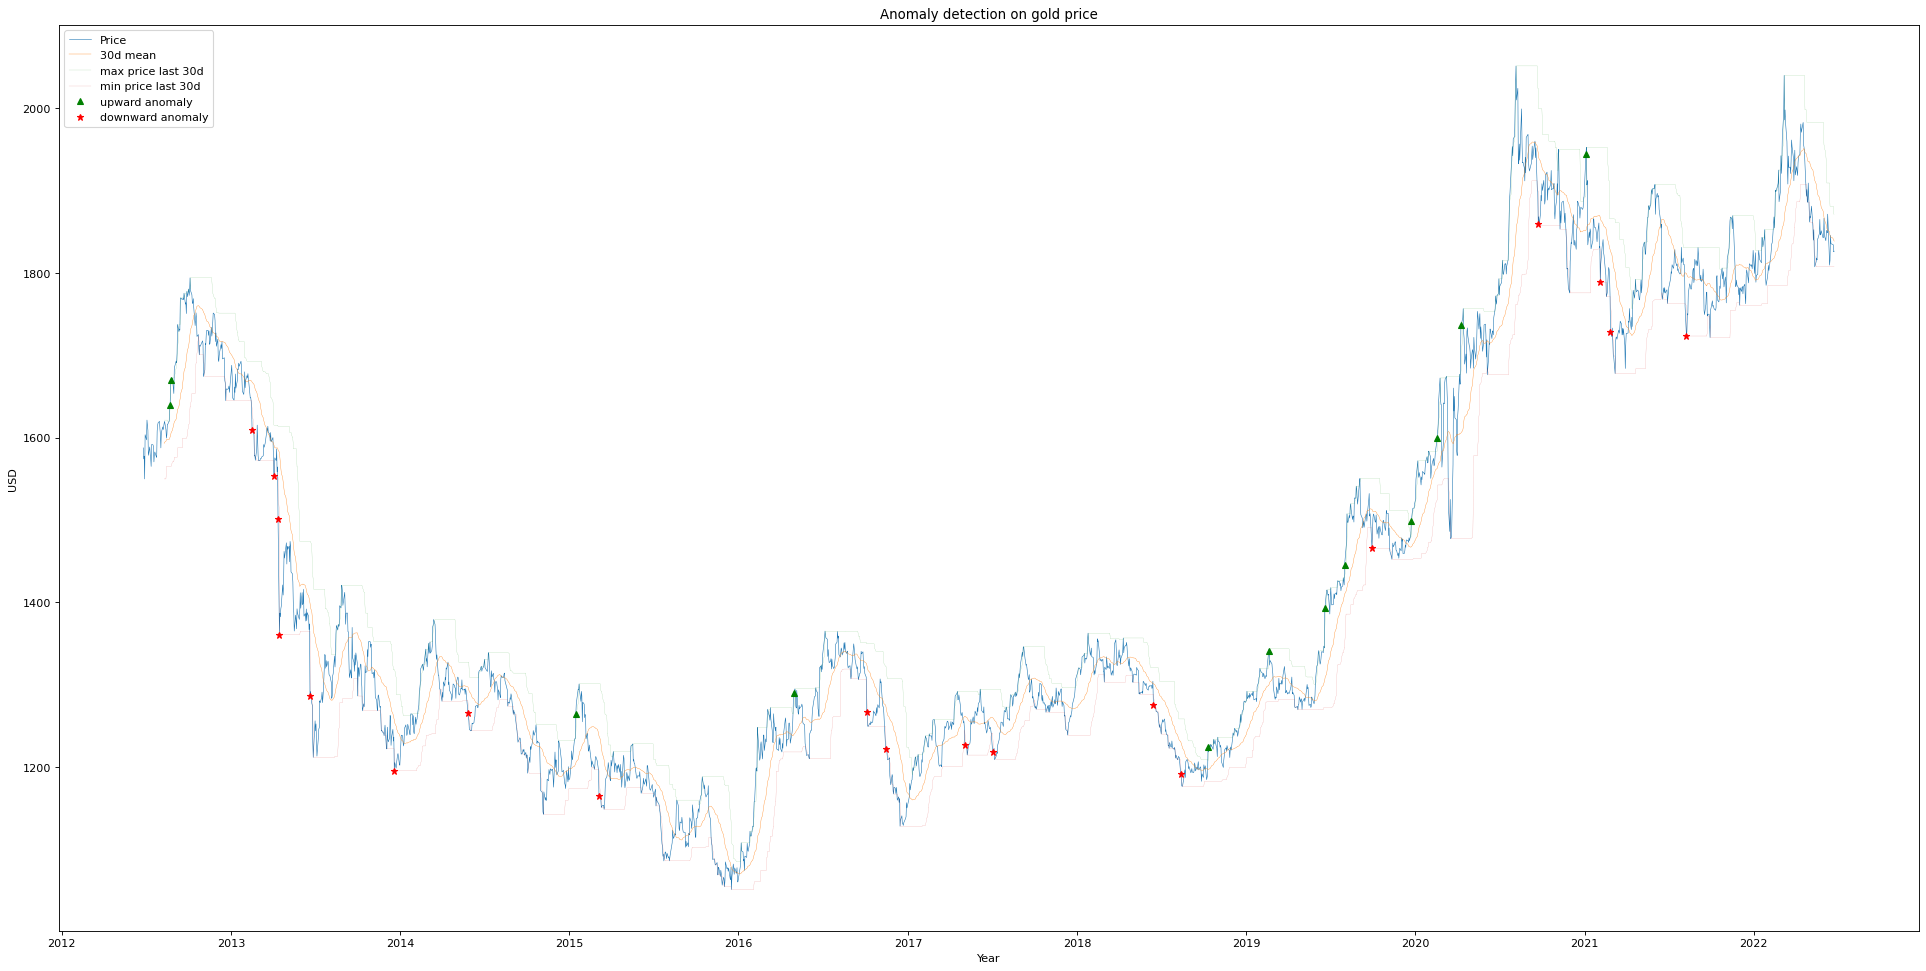

In [11]:
figure(figsize=(30, 15), dpi=80)
plt.plot(df['Price'],label='Price',linewidth=0.5)
plt.plot(df['mean_30d'],label='30d mean',linewidth=0.3)
plt.plot(df['max_30d'],label='max price last 30d',linewidth=0.1)
plt.plot(df['min_30d'],label='min price last 30d',linewidth=0.1)

plt.plot(up_df['Price'],'g^',label='upward anomaly')
plt.plot(down_df['Price'], 'r*',label='downward anomaly')

plt.title('Anomaly detection on gold price')
plt.xlabel('Year')
plt.ylabel('USD')
plt.legend()

plt.show()